# Octane modelling

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.svm import OneClassSVM
from rdkit import Chem


'''custom modules'''
from filter_data import Select_descriptors
from process_data import Scalar
from simmilarity import mean_tanimato,Leverage
from train import Model

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [3]:
df.head(5)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,boiling_point_K
0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,...,14,12,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13,0.9,390.81
1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,...,6,4,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2,-0.1,351.44
2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,...,2,1,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2,-0.5,337.85
3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,Training,100.25,...,10,8,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7,0.3,370.35
4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,NaN,NaN,...,30,31,2.361111,1.666667,NaN,118.17,no alternative,42,2.7,384.62


### 1. Data preprocessing

In [4]:
### 1.1 Remove columns with missing values
misssing_val_cols = df.columns[df.isnull().any()]
print('Columns with missing values are = {}'.format(list(misssing_val_cols)))

Columns with missing values are = ['Compound Name', 'TARGET', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON', 'dev', 'boiling_point_K']


In [5]:
### 1.2 Remove columns with irrelevant to modelling values
df_ = df.drop(misssing_val_cols,axis=1)

irrelevant_to_pred_columns = ['PubChem','ron_choice']

df_ = df_.drop(irrelevant_to_pred_columns,axis=1)

In [6]:
print('final dataset sie = {}'.format(df_.shape))

final dataset sie = (492, 879)


### 2. Split dataset (standartization must be applied on train set only )

In [7]:
seed = 42 # Fix random seed to make split reproducible (experiment must be reproducible)

X_train, X_test, y_train, y_test = train_test_split(df_.drop('y',axis=1), df_['y'], test_size=0.2, random_state=seed)

In [8]:
print('Train dataset size = {}'.format(X_train.shape))
print('Test dataset size = {}'.format(X_test.shape))

Train dataset size = (393, 878)
Test dataset size = (99, 878)


In [9]:
# Normilise features, so varince threshold can be applied
sc         = Scalar('minmax')

# Wrapper feature selector
wrapper    = sfs(SVR(gamma='auto'),
              n_features_to_select=50,
              scoring='neg_mean_squared_error',
              cv=5)

# Applies varience threshold, removes high correlated features, removes higly skewed vars and applies wrapper in the end.

Filter_    = Select_descriptors(0.01,0.95,None,None)

sc.fit(X_train)

In [11]:
X_train  = Filter_.transform(sc.transform(X_train),y_train)

In [12]:
X_train.head(5)

,SMILES,ABC,SpAbs_A,SpMax_A,SpDiam_A,SpMAD_A,VE2_A,nAromAtom,nAtom,nBridgehead,...,JGI7,JGT10,Diameter,Radius,TopoShapeIndex,SRW05,TSRW10,mZagreb1,Complexity,XLogP
0,Cc1c(C)cccc1C,0.742801,0.741973,0.771745,0.813027,0.704412,0.126501,1.0,0.517241,0.0,...,0.0,0.578490,0.375,0.50,0.333333,0.000000,0.549716,0.527132,0.358491,0.640625
1,CC1CCCC(C1)C,0.660152,0.620122,0.717707,0.756099,0.650734,0.183360,0.0,0.620690,0.0,...,0.0,0.537208,0.375,0.50,0.333333,0.000000,0.509673,0.366925,0.273585,0.671875
2,CC(c1ccccc1)(C)C,0.841107,0.816854,0.786660,0.828740,0.650686,0.079701,1.0,0.620690,0.0,...,0.0,0.646033,0.500,0.50,0.666667,0.000000,0.580511,0.590439,0.429245,0.718750
3,CC(CC1CCCCC1)C,0.819045,0.840067,0.717707,0.756099,0.698460,0.085722,0.0,0.827586,0.0,...,0.0,0.457626,0.625,0.50,1.000000,0.000000,0.559529,0.459948,0.367925,0.828125
4,CC1CCC(O1)C,0.580705,0.527266,0.731974,0.678987,0.666967,0.232863,0.0,0.448276,0.0,...,0.0,0.583679,0.375,0.25,1.000000,0.545665,0.719360,0.320413,0.250000,0.265625


In [15]:
ml_model = Model('RF',X_train,y_train,150)

model_   = ml_model.build_model()

[I 2022-05-17 16:48:42,313] A new study created in memory with name: no-name-c1f1cf62-3ab2-4b6a-a413-eb3408c67b3e
[I 2022-05-17 16:48:52,911] Trial 0 finished with value: -7.717741660983657 and parameters: {'max_depth': 6, 'max_leaf_nodes': 8, 'max_features': 11}. Best is trial 0 with value: -7.717741660983657.
[I 2022-05-17 16:48:56,497] Trial 1 finished with value: -8.757561135434239 and parameters: {'max_depth': 16, 'max_leaf_nodes': 4, 'max_features': 27}. Best is trial 0 with value: -7.717741660983657.
[I 2022-05-17 16:49:01,466] Trial 2 finished with value: -7.720489146820111 and parameters: {'max_depth': 33, 'max_leaf_nodes': 7, 'max_features': 21}. Best is trial 0 with value: -7.717741660983657.
[I 2022-05-17 16:49:08,387] Trial 3 finished with value: -6.683426357966914 and parameters: {'max_depth': 10, 'max_leaf_nodes': 17, 'max_features': 23}. Best is trial 3 with value: -6.683426357966914.
[I 2022-05-17 16:49:12,373] Trial 4 finished with value: -7.8150442873866925 and param

In [18]:
X_train.shape

(393, 282)

### Performance on the test set

In [22]:
# Calculate prediction errors
y_pred_test = model_.predict(sc.transform(X_test)[X_train.columns[1:]])
mae         = np.abs(y_test.values-y_pred_test)

Text(0, 0.5, 'expected')

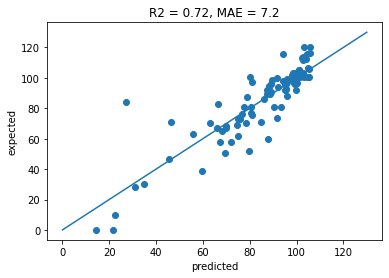

In [28]:
plt.scatter(y_pred_test,y_test)
plt.plot(np.linspace(0,130,10),np.linspace(0,130,10))
plt.title('R2 = {}, MAE = {}'.format(round(r2_score(y_pred_test,y_test),2),round(mean_absolute_error(y_pred_test,y_test),2)))
plt.xlabel('predicted')
plt.ylabel('expected')

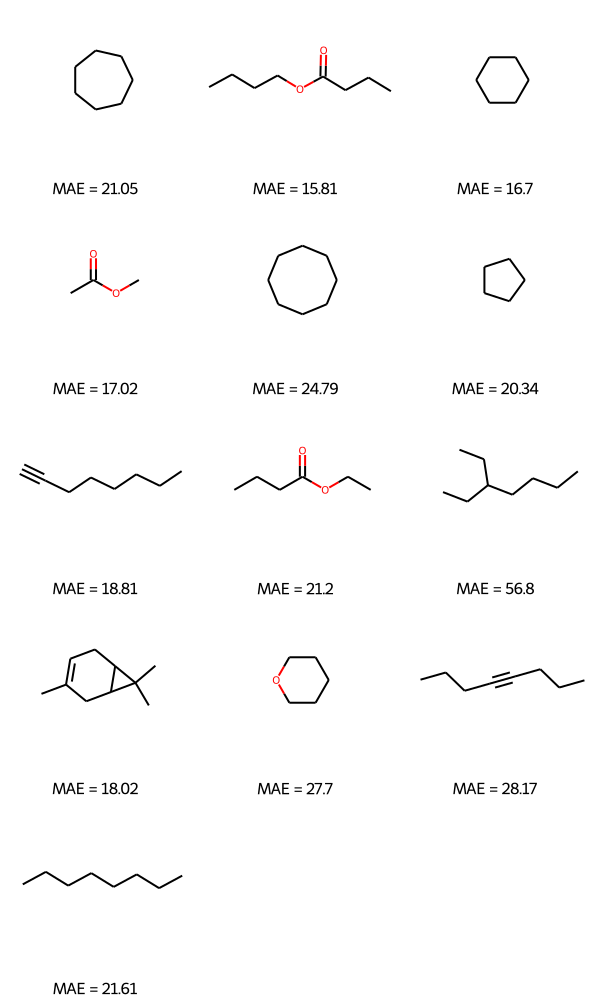

In [29]:
## Display compounds with the worst predictions
abs_error_threshold = 15

data_error = pd.DataFrame(columns=['SMILES','MAE'])
data_error['SMILES'] = X_test.iloc[np.where(mae>abs_error_threshold)[0]]['SMILES'].values
data_error['MAE'] = mae[np.where(mae>abs_error_threshold)[0]]
worst_mols = [Chem.MolFromSmiles(x) for x in data_error['SMILES'].astype('str').values]
Chem.Draw.MolsToGridImage(worst_mols,legends=['MAE'+' '+'='+' '+ str(round(x,2)) for x in list(data_error['MAE'].values)])

### Applicability domain

In [36]:
class Partition:
    def __init__(self,X_train,X_test,MAE,by_type,**kwargs):
        self.X_train  = X_train
        self.X_test   = X_test
        self.distance = self.Distance_model()
        self.by_type  = by_type

    def Distance_model(self):

        if self.by_type == 'Tanimoto':
            return self.X_test['SMILES'].apply(lambda x: DM(x,self.X_train)).values
        elif self.by_Type == 'Leaverage':
            return [Leverage(self.X_test[i,:],self.X_train.values[:,1:]) for i in range(len(self.X_test))]
        else:
            return None

    def distance_bins(self,n_bins):

        error_break_dowm = {}


    def binary_classifier(self,outliers_fraction):

        error_break_down = {}

        for of in outliers_fraction:
            if self.by_type == 'OneClassSVM':
                self.model.nu = of
            else:
                self.model.contamination = of

            self.model.fit(X_train.values[:,1:])
            label = clf.predict((X_test)[X_train.columns[1:]])

            error_break_down[of] =











SyntaxError: invalid syntax (<ipython-input-36-b8994cd46a57>, line 35)

1. OneClassSVM

In [30]:
mean_inside = []

for nu in np.linspace(0.001,0.99,20):

    clf = OneClassSVM(nu=nu, kernel="rbf", gamma=0.1)
    clf.fit(X_train.values[:,1:])
    label = clf.predict(sc.transform(X_test)[X_train.columns[1:]])
    mean_inside.append(mae[np.where(label>0)[0]])

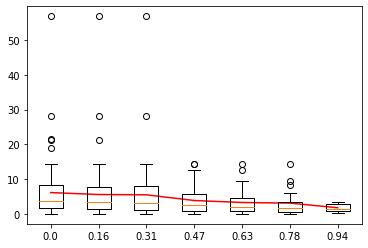

In [31]:
nu_s = [str(round(x,2)) for x in np.linspace(0.001,0.99,20)[np.arange(0,21,3)]]
means_ = np.array(mean_inside)[np.arange(0,21,3)]

plt.plot(np.arange(len(means_)) + 1, [np.mean(x) for x in means_], color='r')
plt.boxplot(means_,labels=nu_s)
plt.show()

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Text(0, 0.5, 'MAE')

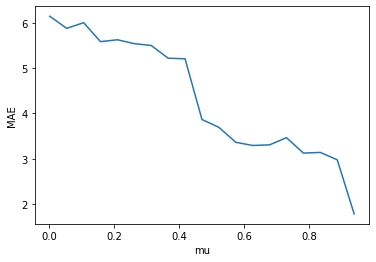

In [32]:
plt.plot(np.linspace(0.001,0.99,20),[np.mean(x) for x in mean_inside])
plt.xlabel('mu')
plt.ylabel('MAE')

2.Tanimato distance

In [79]:
DM = mean_tanimato
Tanimato_dist = X_test['SMILES'].apply(lambda x: DM(x,X_train)).values

Text(0, 0.5, 'MAE')

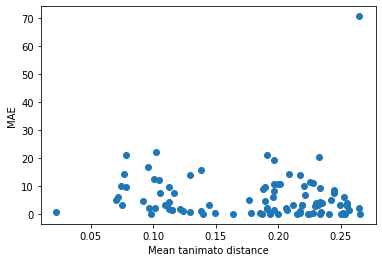

In [80]:
plt.scatter(Tanimato_dist,mae)
plt.xlabel('Mean tanimato distance')
plt.ylabel('MAE')

In [32]:
spread_tanimato = Tanimato_dist.max() - Tanimato_dist.min()

mean_inside2 = []
for i in range(1,20):
    upper_bound = Tanimato_dist.max() - i*spread_tanimato/20
    mean_inside2.append(mae[np.where(Tanimato_dist<upper_bound)[0]].mean())

Text(0, 0.5, 'MAE')

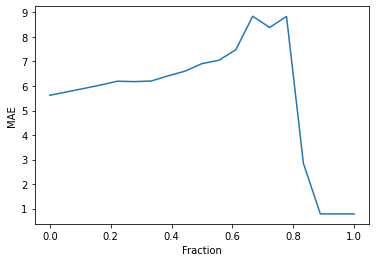

In [33]:
plt.plot(np.linspace(0,1,19),mean_inside2)
plt.xlabel('Fraction')
plt.ylabel('MAE')

In [81]:
dist = Tanimato_dist
df_  = pd.DataFrame(np.vstack((dist,mae)).T,columns=['dist','MAE'])
bins = pd.cut(df_.iloc[:,0], list(np.linspace(dist.max(), dist.min(), 5))[::-1])

In [84]:
for g in df_.groupby(bins)['MAE']:
    print(g[1].mean())

9.94085488119255
6.238384858410039
5.25217823308659
5.8196011477258915


In [87]:
def box_plot(dist,mae):

    df_  = pd.DataFrame(np.vstack((dist,mae)).T,columns=['dist','MAE'])
    bins = pd.cut(df_.iloc[:,0], list(np.linspace(dist.max(), dist.min(), 5))[::-1])

    fig,ax = plt.subplots()
    ax.boxplot([g[1] for g in df_.groupby(bins)['MAE']])
    ax.set_xticklabels(str(g[0])[1:-1] for g in df_.groupby(bins)['MAE'])
    ax.plot(np.arange(4) + 1, [g[1].mean() for  g in df_.groupby(bins)['MAE']], color='r')
    ax.set_xlabel('distance bins')
    ax.set_ylabel('MAE')

    fig.tight_layout()


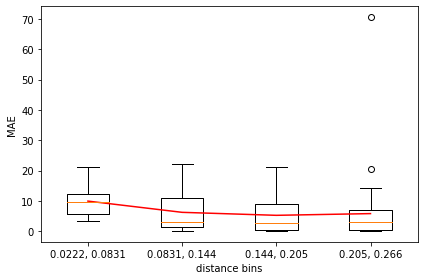

In [88]:
box_plot(Tanimato_dist,mae)

In [97]:
df_  = pd.DataFrame(np.vstack((dist,mae)).T,columns=['dist','MAE'])
bins = pd.cut(df_.iloc[:,0], list(np.linspace(dist.max(), dist.min(), 18))[::-1])

means = [g[1].mean() for  g in df_.groupby(bins)['MAE']]

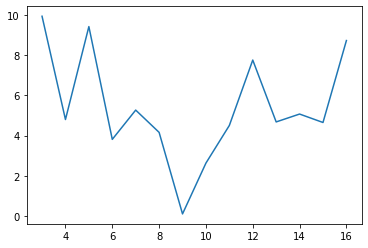

In [98]:
plt.plot(np.arange(len(means)),means)

3. Leaverage distance

In [55]:
x_test_normed = sc.transform(X_test)[X_train.columns].values[:,1:]
lev_dist      = [Leverage(x_test_normed[i,:],X_train.values[:,1:]) for i in range(len(X_test))]

Text(0, 0.5, 'MAE')

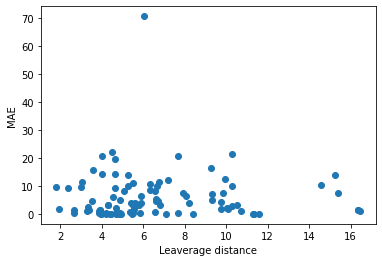

In [57]:
plt.scatter(lev_dist,mae)
plt.xlabel('Leaverage distance')
plt.ylabel('MAE')

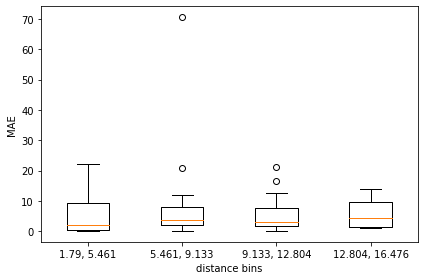

In [86]:
box_plot(np.array(lev_dist),mae)


4. Isolation forest

In [33]:
from sklearn.ensemble import IsolationForest

In [34]:
mean_inside = []

for cont in np.linspace(0.001,0.99,20):

    clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=cont,
                          max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    clf.fit(X_train.values[:,1:])
    label = clf.predict(sc.transform(X_test)[X_train.columns[1:]])
    mean_inside.append(mae[np.where(label>0)[0]].mean())

Text(0, 0.5, 'MAE')

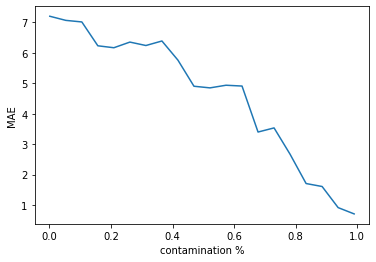

In [35]:
plt.plot(np.linspace(0.001,0.99,20),mean_inside)
plt.xlabel('contamination %')
plt.ylabel('MAE')